In [1]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.3 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import tiktoken

In [3]:
GPT_CONFIG_124M = {
 "vocab_size": 50257, # Vocabulary size
 "context_length": 1024, # Context length
 "emb_dim": 768, # Embedding dimension
 "n_heads": 12, # Number of attention heads
 "n_layers": 12, # Number of layers
 "drop_rate": 0.1, # Dropout rate
 "qkv_bias": False # Query-Key-Value bias
}

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,
                 dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads) == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.dropout = nn.Dropout(dropout)
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer(
            "mask",
            torch.tril(torch.ones(context_length, context_length)))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)
        queries = queries.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2,3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(~mask_bool, -torch.inf)

        attn_weights = torch.softmax(
                attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1,2)
        context_vec = context_vec.contiguous().view(
                b, num_tokens, self.d_out
            )
        context_vec = self.out_proj(context_vec)
        return context_vec

class LayerNorm(nn.Module):
 def __init__(self, emb_dim):
  super().__init__()
  self.eps = 1e-6
  self.scale = nn.Parameter(torch.ones(emb_dim))
  self.shift = nn.Parameter(torch.zeros(emb_dim))

 def forward(self, x):
  mean = x.mean(dim=-1, keepdim=True)
  var = x.var(dim=-1, keepdim=True, unbiased=False)
  norm_x = (x - mean) / torch.sqrt(var + self.eps)
  return self.scale * norm_x + self.shift

class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
    nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
    nn.GELU(),
    nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )
  def forward(self, x):
    return self.layers(x)

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
    d_in=cfg["emb_dim"],
    d_out=cfg["emb_dim"],
    context_length=cfg["context_length"],
    num_heads=cfg["n_heads"],
    dropout=cfg["drop_rate"],
    qkv_bias=cfg["qkv_bias"])
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut
    return x

class GPTModel(nn.Module):
 def __init__(self, cfg):
  super().__init__()
  self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
  self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
  self.drop_emb = nn.Dropout(cfg["drop_rate"])

  self.trf_blocks = nn.Sequential(
  *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

  self.final_norm = LayerNorm(cfg["emb_dim"])
  self.out_head = nn.Linear(
  cfg["emb_dim"], cfg["vocab_size"], bias=False
  )
 def forward(self, in_idx):
  batch_size, seq_len = in_idx.shape
  tok_embeds = self.tok_emb(in_idx)

  pos_embeds = self.pos_emb(
  torch.arange(seq_len, device=in_idx.device)
  )
  x = tok_embeds + pos_embeds
  x = self.drop_emb(x)
  x = self.trf_blocks(x)
  x = self.final_norm(x)
  logits = self.out_head(x)
  return logits

In [5]:
model = GPTModel(GPT_CONFIG_124M)
batch = torch.randint(0, GPT_CONFIG_124M["vocab_size"], (2, GPT_CONFIG_124M["context_length"]))
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[ 5159,  8513,   788,  ..., 48484, 32687, 22673],
        [17257, 39873, 21921,  ..., 27902, 39911, 29211]])

Output shape: torch.Size([2, 1024, 50257])
tensor([[[-0.2813, -0.0560,  0.1757,  ..., -0.7586,  0.2158,  0.5668],
         [-0.5958, -0.2037, -0.2826,  ..., -0.5716,  0.0211,  0.6808],
         [-0.4418,  0.1644,  0.3971,  ..., -1.0777, -0.9343,  0.5004],
         ...,
         [-1.3059,  0.5085,  0.0113,  ...,  0.6477,  0.3444, -0.4158],
         [-0.6967,  0.4364, -0.6756,  ..., -0.2964,  0.4890,  0.2964],
         [-0.5160,  0.0040,  0.3129,  ..., -0.7273,  0.4049, -0.5157]],

        [[ 0.0542,  0.9521, -0.0135,  ...,  0.1371,  0.0125, -0.4602],
         [-0.5869,  0.9697, -0.4701,  ..., -0.3293, -0.3610,  0.2166],
         [-0.9142,  0.2451, -0.4513,  ...,  0.0341, -0.5489,  0.1185],
         ...,
         [-0.8321,  0.2410, -0.1245,  ...,  0.4138,  0.1288, -0.8374],
         [-1.2448,  0.7906, -0.1187,  ...,  0.7184, -0.6230,  0.3535],
         [-0.3

In [6]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,018,752


In [7]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


**Weight tying reduces the overall memory footprint and computational complexity
of the model**

In [8]:
total_params_gpt2 = (
 total_params - sum(p.numel()
 for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
 f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,421,376


In [9]:
# Memory requirements of the 163 million parameters in our GPTModel object

total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.87 MB


# **Generating Texts**

In [10]:
def generate_text_simple(model, idx,
  max_new_tokens, context_size):
  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]
    probas = torch.softmax(logits, dim=-1)
    idx_next = torch.argmax(probas, dim=-1, keepdim=True)
    idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [11]:
tokenizer = tiktoken.get_encoding("gpt2")

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0) #Add batch dimension
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


**Put the model into .eval() mode. This disables random components like
dropout, which are only used during training**

In [12]:
model.eval()
out = generate_text_simple(
 model=model,
 idx=encoded_tensor,
 max_new_tokens=6,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 36935]])
Output length: 5


**Using the .decode method of the tokenizer, we can convert the IDs back into text**

In [13]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am dstg


# Using GPT to generate text

In [14]:
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, #Reduced Context length to 256
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): D

**Utility functions for text to token ids conversion**

In [15]:
def text_to_token_ids(text, tokenizer):
 encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
 encoded_tensor = torch.tensor(encoded).unsqueeze(0) #.unsqueeze(0) adds batch dimension
 return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
 flat = token_ids.squeeze(0) #removes batch dimension
 return tokenizer.decode(flat.tolist())

In [16]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(start_context, tokenizer),
 max_new_tokens=10,
 context_size=GPT_CONFIG_124M["context_length"]
)

In [17]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youLee


## Text Evaluation

In [18]:
#Inputs have been mapped to token IDs
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                          [40, 1107, 588]]) # "I really like"]

In [19]:
#Targets contain Token IDs we want the model to produce
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
 [1107, 588, 11311]]) # " really like chocolate"]

**Feed the inputs into model to calculate logits vectors for the inputs
**

In [20]:
with torch.no_grad():
 logits = model(inputs)
probas = torch.softmax(logits, dim=-1)  #Probability of each token in the vocabulary
print(probas.shape)

torch.Size([2, 3, 50257])



**Applying argmax function to the probability scores to get token IDs**

In [21]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[13195],
         [41034],
         [ 8429]],

        [[19385],
         [40202],
         [23677]]])


 **Convert token IDs back into text. The model produces random text that is different from the target text because it has
not been trained yet**



In [22]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: War probing sword


**initial softmax probability scores corresponding to the target tokens**

In [23]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([1.4403e-05, 1.6720e-05, 8.6229e-06])
Text 2: tensor([1.2030e-05, 4.5597e-05, 6.2099e-05])


**calculate the loss for the probability scores of the two example batches. We apply logarithm to the probability scores**

In [24]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-11.1481, -10.9989, -11.6611, -11.3281,  -9.9957,  -9.6868])


**Combine these log probabilities into a single score by computing the average**

In [25]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.8031)


**Calculating the average negative log probability**

In [26]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.8031)


The term for turning -10.8031 to 10.8031 is called cross entropy loss

In [27]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


For the cross_entropy loss function in PyTorch, we want to flatten these tensors
by combining them over the batch dimension

In [28]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


**Using PyTorch's cross entropy function to calculate loss**

In [29]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.8031)


Calculating Perplexity

In [30]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(49173.1719)


**Perplexity can provide a more interpretable way to understand the uncertainty of a model in predicting the next token in a
sequence**

## Calculating the training and validation set losses

Train on "The Verdict" short story

In [31]:
import urllib.request
url = ("https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
 "the-verdict.txt")
file_path = "the-verdict.txt"
urllib.request.urlretrieve(url, file_path)

('the-verdict.txt', <http.client.HTTPMessage at 0x7d2b4a765590>)

In [32]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
 text_data = file.read()

Check number of characters and tokens in the dataset

In [33]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


**Dividing dataset into a training and a validation set**

Dataloader

In [34]:
from torch.utils.data import Dataset, DataLoader

In [35]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt) #tokenizes the entire text

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]

            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

     #Returns total number of rows in the dataset
    def __len__(self):
        return len(self.input_ids)

    #Returns a single row from the dataset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

    #Dataloader to generate batches with input pairs
    def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128,
                             shuffle=True, drop_last=True, num_workers=0):
        tokenizer = tiktoken.get_encoding("gpt2")
        dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            drop_last=drop_last,
            num_workers=num_workers
        )


        return dataloader

Defining a train_ratio

In [36]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

Creating dataloaders for train_data and val_data

In [37]:
train_loader = GPTDatasetV1.create_dataloader_v1(
 train_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)
val_loader = GPTDatasetV1.create_dataloader_v1(
 val_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

Check if dataloaders were created

In [38]:
print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


Implement utility function to calculate cross entropy loss of a given batch

In [39]:
def calc_loss_batch(input_batch, target_batch, model, device):
 input_batch = input_batch.to(device)
 target_batch = target_batch.to(device)
 logits = model(input_batch)
 loss = torch.nn.functional.cross_entropy(
 logits.flatten(0, 1), target_batch.flatten()
 )
 return loss

**Function to compute training and validation loss**

In [40]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
 total_loss = 0.
 if len(data_loader) == 0:
  return float("nan")
 elif num_batches is None:
  num_batches = len(data_loader)
 else:
  num_batches = min(num_batches, len(data_loader))
 for i, (input_batch, target_batch) in enumerate(data_loader):
  if i < num_batches:
    loss = calc_loss_batch(
      input_batch, target_batch, model, device
    )
    total_loss += loss.item() # Sums loss for each batch
  else:
    break
 return total_loss / num_batches  #Avgs loss over all the batches

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
 train_loss = calc_loss_loader(train_loader, model, device)
 val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 11.002762688530815
Validation loss: 11.05290699005127


# Training an LLM

Implementing LLM training flow

In [42]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
 model.eval()
 with torch.no_grad():
  train_loss = calc_loss_loader(
    train_loader, model, device, num_batches=eval_iter
    )
  val_loss = calc_loss_loader(
    val_loader, model, device, num_batches=eval_iter
  )
 model.train()
 return train_loss, val_loss

In [43]:
def generate_and_print_sample(model, tokenizer, device, start_context):
 model.eval()
 context_size = model.pos_emb.weight.shape[0]
 encoded = text_to_token_ids(start_context, tokenizer).to(device)
 with torch.no_grad():
  token_ids = generate_text_simple(
  model=model, idx=encoded,
  max_new_tokens=50, context_size=context_size
  )
 decoded_text = token_ids_to_text(token_ids, tokenizer)
 print(decoded_text.replace("\n", " "))
 model.train()

In [46]:
def train_model_simple(model, train_loader, val_loader,
 optimizer, device, num_epochs,
 eval_freq, eval_iter, start_context, tokenizer):
 train_losses, val_losses, track_tokens_seen = [], [], []
 tokens_seen, global_step = 0, -1
 for epoch in range(num_epochs):
  model.train()
  for input_batch, target_batch in train_loader:
    optimizer.zero_grad()
    loss = calc_loss_batch(
      input_batch, target_batch, model, device
      )
    loss.backward()
    optimizer.step()
    tokens_seen += input_batch.numel()
    global_step += 1
    if global_step % eval_freq == 0:
      train_loss, val_loss = evaluate_model(
        model, train_loader, val_loader, device, eval_iter)
      train_losses.append(train_loss)
      val_losses.append(val_loss)
      track_tokens_seen.append(tokens_seen)
      print(f"Ep {epoch+1} (Step {global_step:06d}): "
      f"Train loss {train_loss:.3f}, "
      f"Val loss {val_loss:.3f}"
      )
  generate_and_print_sample(
    model, tokenizer, device, start_context
  )
 return train_losses, val_losses, track_tokens_seen

In [47]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
 model.parameters(),
 lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
 model, train_loader, val_loader, optimizer, device,
 num_epochs=num_epochs, eval_freq=5, eval_iter=5,
 start_context="Every effort moves you, ", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.868, Val loss 10.099
Ep 1 (Step 000005): Train loss 8.115, Val loss 8.253
Every effort moves you, ,
Ep 2 (Step 000010): Train loss 6.662, Val loss 7.041
Ep 2 (Step 000015): Train loss 5.962, Val loss 6.549
Every effort moves you, ,
Ep 3 (Step 000020): Train loss 5.650, Val loss 6.538
Ep 3 (Step 000025): Train loss 6.298, Val loss 7.969
Every effort moves you, ,
Ep 4 (Step 000030): Train loss 5.091, Val loss 6.421
Ep 4 (Step 000035): Train loss 4.599, Val loss 6.404
Every effort moves you,  was
Ep 5 (Step 000040): Train loss 3.691, Val loss 6.291
Every effort moves you,  through
Ep 6 (Step 000045): Train loss 3.679, Val loss 6.202
Ep 6 (Step 000050): Train loss 3.060, Val loss 6.172
Every effort moves you,  I
Ep 7 (Step 000055): Train loss 2.739, Val loss 6.195
Ep 7 (Step 000060): Train loss 2.200, Val loss 6.244
Every effort moves you,  through
Ep 8 (Step 000065): Train loss 1.956, Val loss 6.195
Ep 8 (Step 000070): Train loss 1.393, Val loss 6.221
Ever

Plot to show training and validation losses

In [48]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

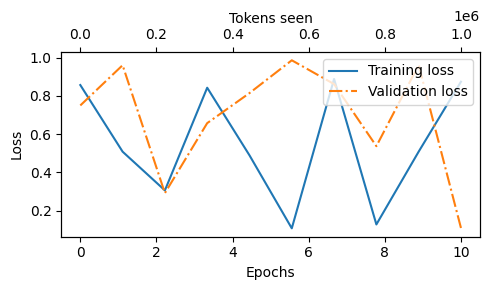

In [54]:
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()  # Create a second x-axis for tokens seen
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for alignment
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# Text Generation Strategies

In [55]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): Dropout(p=0.1, inplace=False)
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (dropout): D

In [58]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids("Every effort moves you,", tokenizer),
 max_new_tokens=25,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you, through


**Temperature scaling** - It is just dividing logits by a numer greater than 0

Adding a probabilistic selection
process to the next-token generation task

In [60]:
vocab = {
 "closer": 0,
 "every": 1,
 "effort": 2,
 "forward": 3,
 "inches": 4,
 "moves": 5,
 "pizza": 6,
 "toward": 7,
 "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

assume the LLM is given the start context "every effort moves you" and generates the following next-token logits

In [61]:
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

we convert the logits into
probabilities via the softmax function and obtain the token ID corresponding to the
generated token

In [62]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


To implement a probabilistic sampling process, we can now replace argmax with
the multinomial function

In [64]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


The multinomial
function samples the next token proportional to its probability score

In [65]:
def softmax_with_temperature(logits, temperature):
 scaled_logits = logits / temperature
 return torch.softmax(scaled_logits, dim=0)

Plotting the original probabilities alongside probabilities scaled with different temperature values

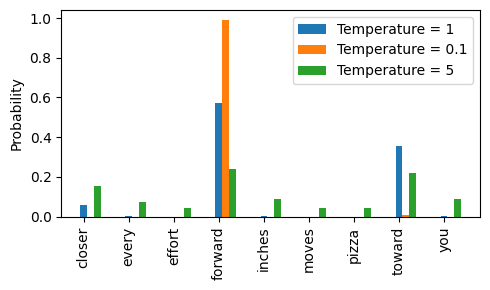

In [66]:
temperatures = [1, 0.1, 5] # original,lower and higher confidence
scaled_probas = [softmax_with_temperature(next_token_logits, T)
 for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
 rects = ax.bar(x + i * bar_width, scaled_probas[i],
  bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()